---
## Data Prep

### Dataset Cleaning

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import fbeta_score, accuracy_score

sns.set()

In [26]:
features_raw = pd.read_csv('../data/interim/features_raw.csv', index_col='Id')

In [27]:
features_raw.isna().sum().sort_values(ascending=False).head(10)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
dtype: int64

In [28]:
nan_count = features_raw.isna().sum()
nan_count = nan_count[nan_count > 0]
nan_count

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [10]:
nan_count.shape

(19,)

In [11]:
(nan_count / features_raw.shape[0]).sort_values(ascending=False)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageYrBlt     0.055479
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

In [12]:
cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']
features_cleaned = features_raw.drop(columns=cols)
dropped_cols = cols

In [13]:
# Get info for remaining NaN columns
nan_count = features_cleaned.isna().sum()
nan_count = nan_count[nan_count > 0]
features_cleaned[nan_count.index].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   MasVnrType    1452 non-null   object 
 2   MasVnrArea    1452 non-null   float64
 3   BsmtQual      1423 non-null   object 
 4   BsmtCond      1423 non-null   object 
 5   BsmtExposure  1422 non-null   object 
 6   BsmtFinType1  1423 non-null   object 
 7   BsmtFinType2  1422 non-null   object 
 8   Electrical    1459 non-null   object 
 9   FireplaceQu   770 non-null    object 
 10  GarageType    1379 non-null   object 
 11  GarageYrBlt   1379 non-null   float64
 12  GarageFinish  1379 non-null   object 
 13  GarageQual    1379 non-null   object 
 14  GarageCond    1379 non-null   object 
dtypes: float64(3), object(12)
memory usage: 182.5+ KB


In [14]:
# Fill remaining NaN values with mean of each column
nan_numerical = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
nan_categorical = ['MasVnrType','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                    'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType',
                    'GarageFinish', 'GarageQual', 'GarageCond']

features_cleaned[nan_numerical] = features_cleaned[nan_numerical].fillna(features_cleaned[nan_numerical].mean(), axis=0)
features_cleaned[nan_categorical] = features_cleaned[nan_categorical].fillna('MSNG', axis=0)

### Transforming Skewed Continuous Features

A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. We'll need to check the following continuous data features for 'skew'.

- LotFrontage
- LotArea
- MasVnrArea
- BsmtFinSF1
- BsmtFinSF2
- TotalBsmtSF
- 1stFlrSF
- 2ndFlrSF
- LowQualFinSF
- GrLivArea
- GarageArea
- WoodDeckSF
- OpenPorchSF
- EnclosedPorch
- 3SsnPorch
- ScreenPorch
- PoolArea
- MiscVal

In [15]:
continuous_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', 
        '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

skew = features_cleaned[continuous_cols].skew().sort_index()
skew

1stFlrSF          1.376757
2ndFlrSF          0.813030
3SsnPorch        10.304342
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
EnclosedPorch     3.089872
GarageArea        0.179981
GrLivArea         1.366560
LotArea          12.207688
LotFrontage       2.384950
LowQualFinSF      9.011341
MasVnrArea        2.676412
MiscVal          24.476794
OpenPorchSF       2.364342
PoolArea         14.828374
ScreenPorch       4.122214
TotalBsmtSF       1.524255
WoodDeckSF        1.541376
dtype: float64

In [16]:
# Show columns with skew greater than 2 * Standard Error
skew > 2 * features_cleaned[continuous_cols].sem().sort_index()

1stFlrSF         False
2ndFlrSF         False
3SsnPorch         True
BsmtFinSF1       False
BsmtFinSF2       False
EnclosedPorch    False
GarageArea       False
GrLivArea        False
LotArea          False
LotFrontage       True
LowQualFinSF      True
MasVnrArea       False
MiscVal          False
OpenPorchSF      False
PoolArea          True
ScreenPorch       True
TotalBsmtSF      False
WoodDeckSF       False
dtype: bool

<ipython-input-17-d95a134964be>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


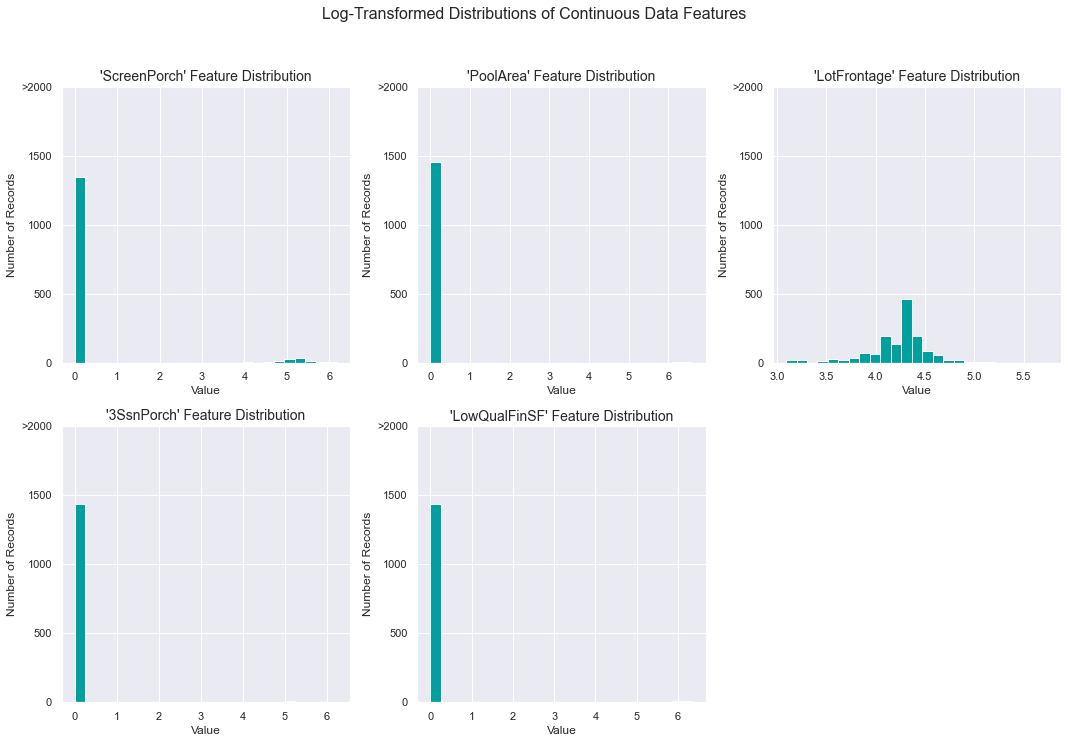

In [17]:
skewed = ['ScreenPorch', 'PoolArea', 'LotFrontage', '3SsnPorch', 'LowQualFinSF']
features_log_transformed = pd.DataFrame(data = features_cleaned)
features_log_transformed[skewed] = features_cleaned[skewed].apply(lambda x: np.log(x + 1))

fig = plt.figure(figsize = (15,10));

# Skewed feature plotting
for i, feature in enumerate(skewed):
    ax = fig.add_subplot(2, 3, i+1)
    ax.hist(features_log_transformed[feature], bins = 25, color = '#00A0A0')
    ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    ax.set_ylim((0, 2000))
    ax.set_yticks([0, 500, 1000, 1500, 2000])
    ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

# Plot aesthetics
fig.suptitle("Log-Transformed Distributions of Continuous Data Features", \
        fontsize = 16, y = 1.03)

fig.tight_layout()
fig.show()

### Normalizing Numerical Features

In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as 'capital-gain' or 'capital-loss' above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.
Run the code cell below to normalize each numerical feature. We will use sklearn.preprocessing.MinMaxScaler for this.

In [18]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = features_log_transformed.select_dtypes(include=np.number).columns

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
features_log_minmax_transform.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,0.235294,RL,0.413268,0.033420,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.111517,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,WD,Normal
2,0.000000,RL,0.490307,0.038795,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25,WD,Normal
3,0.235294,RL,0.429990,0.046507,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0.076782,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50,WD,Normal
4,0.294118,RL,0.383633,0.038561,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0.063985,0.492754,0.0,0.0,0.0,0.0,0.090909,0.00,WD,Abnorml
5,0.235294,RL,0.508439,0.060576,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0.153565,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50,WD,Normal


### Data Preprocessing

Our earlier data exploration shows that there are several features for each record that are non-numeric or categorical. Since learning algorithms generally expect input to be numeric, we'll need to convert these categorical features. In our case, we'll use One-hot encoding to create a _"dummy"_ variable for each possible category of each non-numeric feature.

In [19]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print(f'{len(encoded)} total features after one-hot encoding.')

# Uncomment the following line to see the encoded feature names
# print(encoded)

287 total features after one-hot encoding.


In [20]:
features_final.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,0.235294,0.413268,0.033420,0.666667,0.500,0.949275,0.883333,0.12250,0.125089,0.0,...,0,0,0,1,0,0,0,0,1,0
2,0.000000,0.490307,0.038795,0.555556,0.875,0.753623,0.433333,0.00000,0.173281,0.0,...,0,0,0,1,0,0,0,0,1,0
3,0.235294,0.429990,0.046507,0.666667,0.500,0.934783,0.866667,0.10125,0.086109,0.0,...,0,0,0,1,0,0,0,0,1,0
4,0.294118,0.383633,0.038561,0.666667,0.500,0.311594,0.333333,0.00000,0.038271,0.0,...,0,0,0,1,1,0,0,0,0,0
5,0.235294,0.508439,0.060576,0.777778,0.500,0.927536,0.833333,0.21875,0.116052,0.0,...,0,0,0,1,0,0,0,0,1,0


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [21]:
# train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    saleprice, 
                                                    test_size = 0.2, # Check if should be train_size
                                                    random_state = 5)

# Show the results of the split
print(f'Training set has {X_train.shape[0]} samples.')
print(f'Testing set has {X_test.shape[0]} samples.')

Training set has 1168 samples.
Testing set has 292 samples.


In [22]:
# Stratified Shuffle Split - Come back to this later
# from sklearn.model_selection import StratifiedShuffleSplit
# ss = StratifiedShuffleSplit(test_size=0.2, random_state=5)

# i = 0
# for train_idx, test_idx in ss.split(np.zeros(features_final.shape[0]), features_final['OverallQual']):
#     X_train = features_final.iloc[train_idx]
#     y_train = saleprice.iloc[train_idx]
#     X_test = features_final.iloc[test_idx]
#     y_test = saleprice.iloc[test_idx]

# # Show the results of the split
# print(f'Training set has {X_train.shape[0]} samples.')
# print(f'Testing set has {X_test.shape[0]} samples.')